# Vertical coords

In [19]:
from dask.distributed import Client
import os
from intake import open_esm_datastore, cat
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from ruamel.yaml import YAML
ryaml = YAML()
ryaml.preserve_quotes = True
import math
from scipy.spatial import cKDTree

In [2]:
xr.set_options(keep_attrs=True); # cf_xarray works best when xarray keeps attributes by default

In [3]:
client = Client(threads_per_worker=1)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34677 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34677/status,
Dashboard: /proxy/34677/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43727,Workers: 7
Dashboard: /proxy/34677/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:35977,Total threads: 1
Dashboard: /proxy/39049/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:45693,


### Extracts experiment datasets

In [4]:
# from https://github.com/COSIMA/cosima-recipes/blob/main/Tutorials/ACCESS-NRI_Intake_Catalog.ipynb
# Try passing the following argument to your to_dask or to_dataset_dict call:
# See the xarray documentation on Reading multi-file datasets for more details about these arguments.
# https://docs.xarray.dev/en/stable/user-guide/io.html#reading-multi-file-datasets

xarray_combine_by_coords_kwargs=dict(
    compat="override",
    data_vars="minimal",
    coords="minimal"
)

def extract_expts_dataset(datastore, variable, time_range=None, frequency='1mon', path='.*output.*', xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs):
    dataset = datastore.search(frequency=frequency,
                               variable=variable,
                               path=path,
                               ).to_dask(xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs)
    if time_range is not None: # not scalar data
        dataset = dataset.sel(time=slice(time_range[0],time_range[1]))
    return dataset

### Loading datastore for different OM3 experiments

1. Reads yaml input file by `_read_ryaml`.
2. Organises OM3 experiments using `organise_input_info`, resulting in lists of `datastore`s.

In [5]:
def _read_ryaml(yaml_path):
    """ Read yaml file and preserve comments"""
    with open(yaml_path, "r") as f:
        return ryaml.load(f)

def organise_input_info(MOM_dirs, MOM_names, MOM_full_paths):
    datastore_tot = []
    MOM_names_tot = []
    MOM_dirs_path_tot = []
    intake_esm_ds = 'intake_esm_ds.json'
    for i,j,k in zip(MOM_dirs,MOM_names,MOM_full_paths):
        archive_path = os.path.join(f"{output_expt_path}",f"{i}","archive")
        datastore_path = os.path.join(f"{archive_path}",intake_esm_ds)
        if os.path.isfile(datastore_path):
            datastore = open_esm_datastore(datastore_path,columns_with_iterables=["variable"])
            datastore_tot.append(datastore)
            MOM_names_tot.append(f"{j}")
            MOM_dirs_path_tot.append(f"{k}")
    return datastore_tot, MOM_names_tot, MOM_dirs_path_tot

In [6]:
expts_manager_path = '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager'
yamlfile_path = os.path.join(expts_manager_path, 'Expts_manager-025deg-75-layers_modify.yaml')

yaml_input = _read_ryaml(yamlfile_path)
test_rel_path = yaml_input['test_path']
output_expt_path = os.path.join(expts_manager_path, test_rel_path)

MOM_dirs = (
            yaml_input['namelists']['cross_block3_fix_runoff1']['cross_block3_fix_runoff1_dirs'] + # ePBL+fix_runoff
            yaml_input['namelists']['cross_block3_fix_runoff2']['cross_block3_fix_runoff2_dirs'] + # ePBL+fix_runoff+RIVERMIX_DEPTH40
            yaml_input['namelists']['cross_block3_fix_runoff4']['cross_block3_fix_runoff4_dirs']   # kpp+fix_runoff
) # implicit
MOM_names = [
    "ePBL+fix_runoff",
    "ePBL+fix_runoff+RIVERMIX_DEPTH40",
    "kpp+fix_runoff",
] # user-defined

MOM_full_paths= [os.path.join(expts_manager_path, test_rel_path, MOM_dir) for MOM_dir in MOM_dirs]
datastore_tot, MOM_names_tot, MOM_dirs_path_tot = organise_input_info(MOM_dirs, MOM_names, MOM_full_paths)

In [7]:
datastore_tot

[<intake_esm_ds catalog with 167 dataset(s) from 6798 asset(s)>,
 <intake_esm_ds catalog with 167 dataset(s) from 6798 asset(s)>,
 <intake_esm_ds catalog with 142 dataset(s) from 4514 asset(s)>]

In [8]:
MOM_dirs_path_tot

['/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_0.25deg_new_topo_modify/epbl_1_om5_fix_runoff',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_0.25deg_new_topo_modify/epbl_1_om5_fix_runoff_rivermix_40',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_0.25deg_new_topo_modify/kpp_fix_runoff']

In [9]:
time_range = ['1900-01-01', '1904-01-01']

In [10]:
variable_om3 = "salt_flux_added"
salt_flux_added_comparisons = []
for datastore in datastore_tot:
    salt_flux_added_comparisons.append(extract_expts_dataset(datastore, variable_om3, time_range))

In [11]:
variable_om3 = "sos"
sos_comparisons = []
for datastore in datastore_tot:
    sos_comparisons.append(extract_expts_dataset(datastore, variable_om3, time_range))

In [12]:
variable_om3 = "so"
so_comparisons = []
for datastore in datastore_tot:
    so_comparisons.append(extract_expts_dataset(datastore, variable_om3, time_range))

In [13]:
variable_om3 = "e"
e_comparisons = []
for datastore in datastore_tot:
    e_comparisons.append(extract_expts_dataset(datastore, variable_om3, time_range))

In [14]:
def coords_river_mouth(jra55dopaths, sel_lat_range, sel_lon_range):
    jra55do = xr.open_mfdataset([v for v in jra55dopaths.values()])

    def convert_lon_custom(lon):
        return lon - 360 if lon > 80 else lon

    tmp_lon = np.vectorize(convert_lon_custom)(jra55do.lon.values)
    sorted_lon_indices = np.argsort(tmp_lon)
    tmp_lon_sorted = tmp_lon[sorted_lon_indices]

    friver_mean = jra55do.friver.mean(dim="time").compute()
    friver_sorted = friver_mean[:, sorted_lon_indices]
    friver_sorted = friver_sorted.assign_coords(lon=tmp_lon_sorted)

    friver_selected = friver_sorted.sel(
        lat=slice(sel_lat_range[0], sel_lat_range[1]),
        lon=slice(sel_lon_range[0], sel_lon_range[1]),
    )
    friver_mask = friver_selected > 0
    lat_values = friver_selected.lat.values
    lon_values = friver_selected.lon.values

    nonzero_indices = np.where(friver_mask)
    
    nonzero_lat = lat_values[nonzero_indices[0]]
    nonzero_lon = lon_values[nonzero_indices[1]]
    
    for lat, lon in zip(nonzero_indices[0], nonzero_indices[1]):
        print(f"Runoff at (Lat: {lat_values[lat]}, Lon: {lon_values[lon]}) with {friver_selected[lat, lon].values}")

    fig, ax = plt.subplots(figsize=(8, 6))
    
    pc = ax.pcolormesh(tmp_lon_sorted, jra55do.lat, np.log(friver_sorted))

    ax.scatter(nonzero_lon, nonzero_lat, color="red", marker="x", label="Runoff Locations")
    plt.colorbar(pc, label="River Runoff (kg/m²/s)")
    ax.legend()
    ax.set_title(f"Runoff at (Lat: {lat_values[lat]}, Lon: {lon_values[lon]})")
    plt.show()
    return nonzero_lat, nonzero_lon

In [16]:
jra55dopaths = {
    'areacello': '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/ocean/fx/areacello/gr/v20190429/areacello_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr.nc',
    'friver': '/g/data/vk83/configurations/inputs/JRA-55/RYF/v1-4/data/RYF.friver.1990_1991.nc',
    'licalvf': '/g/data/vk83/configurations/inputs/JRA-55/RYF/v1-4/data/RYF.licalvf.1990_1991.nc'
}

Runoff at (Lat: -1.375, Lon: -48.625) with 0.01720200851559639
Runoff at (Lat: -1.375, Lon: -48.375) with 0.0006719936500303447
Runoff at (Lat: -1.125, Lon: -48.625) with 6.443645543185994e-05
Runoff at (Lat: -1.125, Lon: -48.375) with 2.027085065492429e-05
Runoff at (Lat: -0.875, Lon: -48.625) with 1.1589809219003655e-05
Runoff at (Lat: -0.875, Lon: -48.125) with 1.1012782124453224e-05
Runoff at (Lat: -0.625, Lon: -48.375) with 3.038808426936157e-05
Runoff at (Lat: -0.625, Lon: -48.125) with 2.581849685157067e-06
Runoff at (Lat: -0.625, Lon: -47.875) with 5.084541407995857e-05
Runoff at (Lat: -0.625, Lon: -47.625) with 9.36108990572393e-05
Runoff at (Lat: -0.125, Lon: -49.375) with 0.25923559069633484
Runoff at (Lat: -0.125, Lon: -49.125) with 5.3896044846624136e-05
Runoff at (Lat: -0.125, Lon: -48.875) with 5.493287608260289e-05
Runoff at (Lat: -0.125, Lon: -48.625) with 5.0063299568137154e-05


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


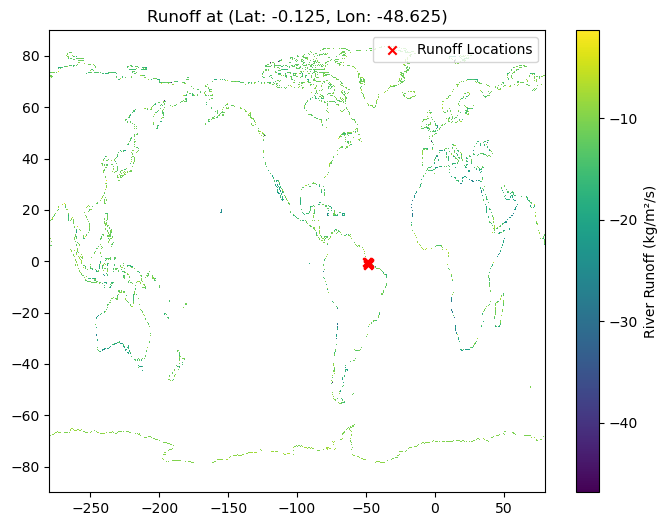

In [17]:
sel_lat_range = [-2.5, 0]
sel_lon_range = [-50, -47.5]
nonzero_lat, nonzero_lon = coords_river_mouth(jra55dopaths, sel_lat_range, sel_lon_range)

In [18]:
static = datastore_tot[0].search(path='.*output000.*',
                          frequency='fx', variable=['xh', 'yh', 'deptho', 'geolon', 'geolat']
                         ).to_dask(xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs)

In [20]:
def construct_lon_lat(xh, yh, target_lon, target_lat, ds, var_name):
    if hasattr(xh, "values"):
        xh = xh.values
    if hasattr(yh, "values"):
        yh = yh.values
    lon_2d, lat_2d = np.meshgrid(xh, yh)
    coords_flat = np.column_stack((lat_2d.ravel(), lon_2d.ravel()))
    tree = cKDTree(coords_flat)
    def find_valid_indices(target_lon, target_lat):

        _, nearest_idx = tree.query([target_lat, target_lon])
        nearest_yh_idx, nearest_xh_idx = np.unravel_index(nearest_idx, lon_2d.shape)

        e_values = ds[var_name].isel(yh=nearest_yh_idx, xh=nearest_xh_idx)
        if not np.isnan(e_values).all():
            return nearest_xh_idx, nearest_yh_idx, lon_2d[nearest_yh_idx, nearest_xh_idx], lat_2d[nearest_yh_idx, nearest_xh_idx]

        for i in range(1, 20):  # Search up to 20 closest points
            _, new_nearest_idx = tree.query([target_lat, target_lon], k=i + 1)
            new_yh_idx, new_xh_idx = np.unravel_index(new_nearest_idx[-1], lon_2d.shape)

            e_values = ds[var_name].isel(yh=new_yh_idx, xh=new_xh_idx)
            if not np.isnan(e_values).all():
                return new_xh_idx, new_yh_idx, lon_2d[new_yh_idx, new_xh_idx], lat_2d[new_yh_idx, new_xh_idx]

        return None, None, None, None  # If no valid point is found

    lon_indx, lat_indx, lon, lat = [], [], [], []
    for i in range(len(target_lon)):
        lon_idx, lat_idx, lon_tmp, lat_tmp = find_valid_indices(target_lon[i], target_lat[i])
        if lon_idx is not None:  # If a valid location is found
            lon_indx.append(lon_idx)
            lat_indx.append(lat_idx)
            lon.append(lon_tmp)
            lat.append(lat_tmp)
        else:
            print(f"Warning: No valid location found near ({target_lon[i]}, {target_lat[i]})")

    return lon_indx, lat_indx, lon, lat

In [21]:
target_lon = [-49.375]
target_lat = [-0.125]
variable_om3 = "e"
ds = e_comparisons[0]
lon_indx, lat_indx, lon, lat = construct_lon_lat(static.xh, static.yh, target_lon, target_lat, ds, variable_om3)

In [22]:
print(lon_indx, lat_indx, lon, lat)

[922] [556] [-49.375] [0.0]


In [24]:
time_tmp = e_comparisons[0]["e"]["time"].values

In [25]:
def fix_contourf(nc_object, nc_object2, lat_indx, lon_indx, time_plot, levels=10, ax=None, clim=None, plot_grid=True, np_log=False, ylim=None):
    e = nc_object['e'].isel(yh=lat_indx, xh=lon_indx)
    e = e.T
    z = (e[:-1, :] + e[1:, :]) / 2

    S = nc_object2['so'].isel(yh=lat_indx, xh=lon_indx)
    S = S.T
    z = np.vstack((e[0, :], z, e[-1, :]))
    S = np.vstack((S[0, :], S))

    time_np = time_plot.astype("datetime64[ns]")
    x = time_np[np.newaxis, :] + (0 * z).astype("timedelta64[D]")

    print(f"{x.shape=}, {z.shape=}, {S.shape=}")

    if ax is None:
        ax = plt.gca()

    if np_log:
        S = np.log(S)

    if clim is None:
        vmin, vmax = np.nanmin(S), np.nanmax(S)
    else:
        vmin, vmax = clim  # Use provided limits

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    levels = np.linspace(vmin, vmax, levels)
    plot1 = ax.contourf(x, z, S, levels=levels, cmap="viridis", norm=norm)
    cbar = plt.colorbar(plot1, ax=ax, orientation="vertical")
    cbar.set_label("Salinity")
    if plot_grid:
        ax.plot(time_plot, e.T, 'k')
    if ylim is not None:
        ax.set_ylim(ylim)
    return plot1


In [26]:
target_lon = [-49.375]
target_lat = [-0.125]
variable_om3 = "e"
ds = e_comparisons[0]
lon_indx, lat_indx, lon, lat = construct_lon_lat(static.xh, static.yh, target_lon, target_lat, ds, variable_om3)

x.shape=(76, 48), z.shape=(76, 48), S.shape=(76, 48)
x.shape=(76, 48), z.shape=(76, 48), S.shape=(76, 48)
x.shape=(76, 48), z.shape=(76, 48), S.shape=(76, 48)


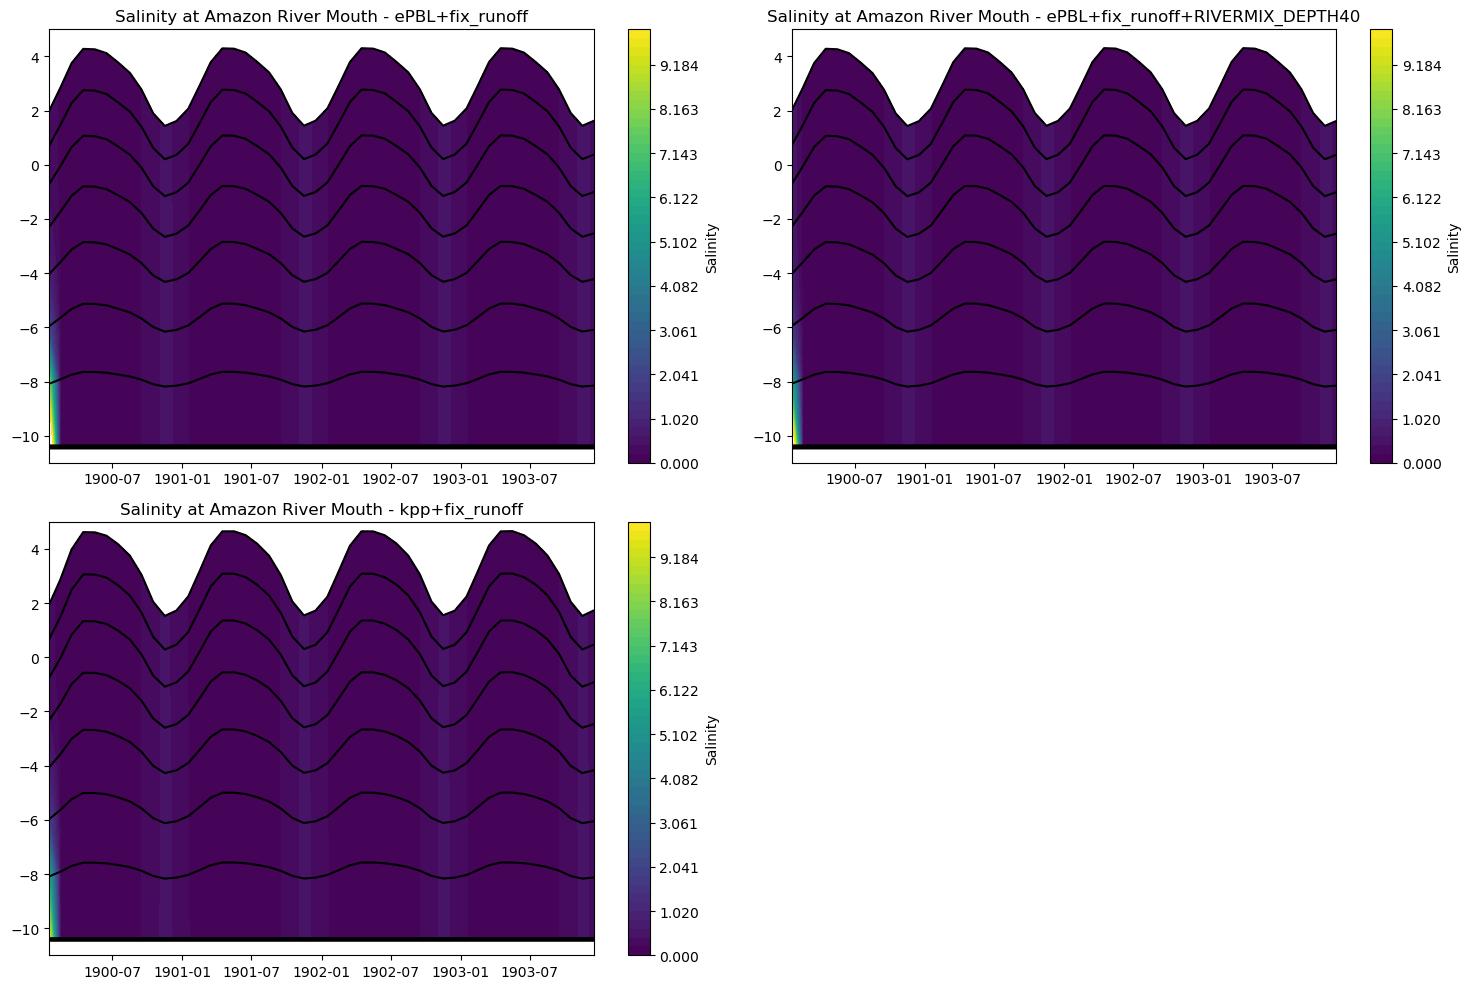

In [27]:
num_comparisons = len(e_comparisons)
ncols = 2
nrows = math.ceil(num_comparisons / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()
if num_comparisons == 1:
    axes = [axes]
for i in range(num_comparisons):
    fix_contourf(e_comparisons[i], so_comparisons[i], lat_indx[0], lon_indx[0], time_tmp, levels=50, ax=axes[i], clim=[0, 10], np_log=False, ylim=[-11,5])
    axes[i].set_title(f'Salinity at Amazon River Mouth - {MOM_names[i]}')

for j in range(num_comparisons, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

x.shape=(76, 48), z.shape=(76, 48), S.shape=(76, 48)
x.shape=(76, 48), z.shape=(76, 48), S.shape=(76, 48)
x.shape=(76, 48), z.shape=(76, 48), S.shape=(76, 48)


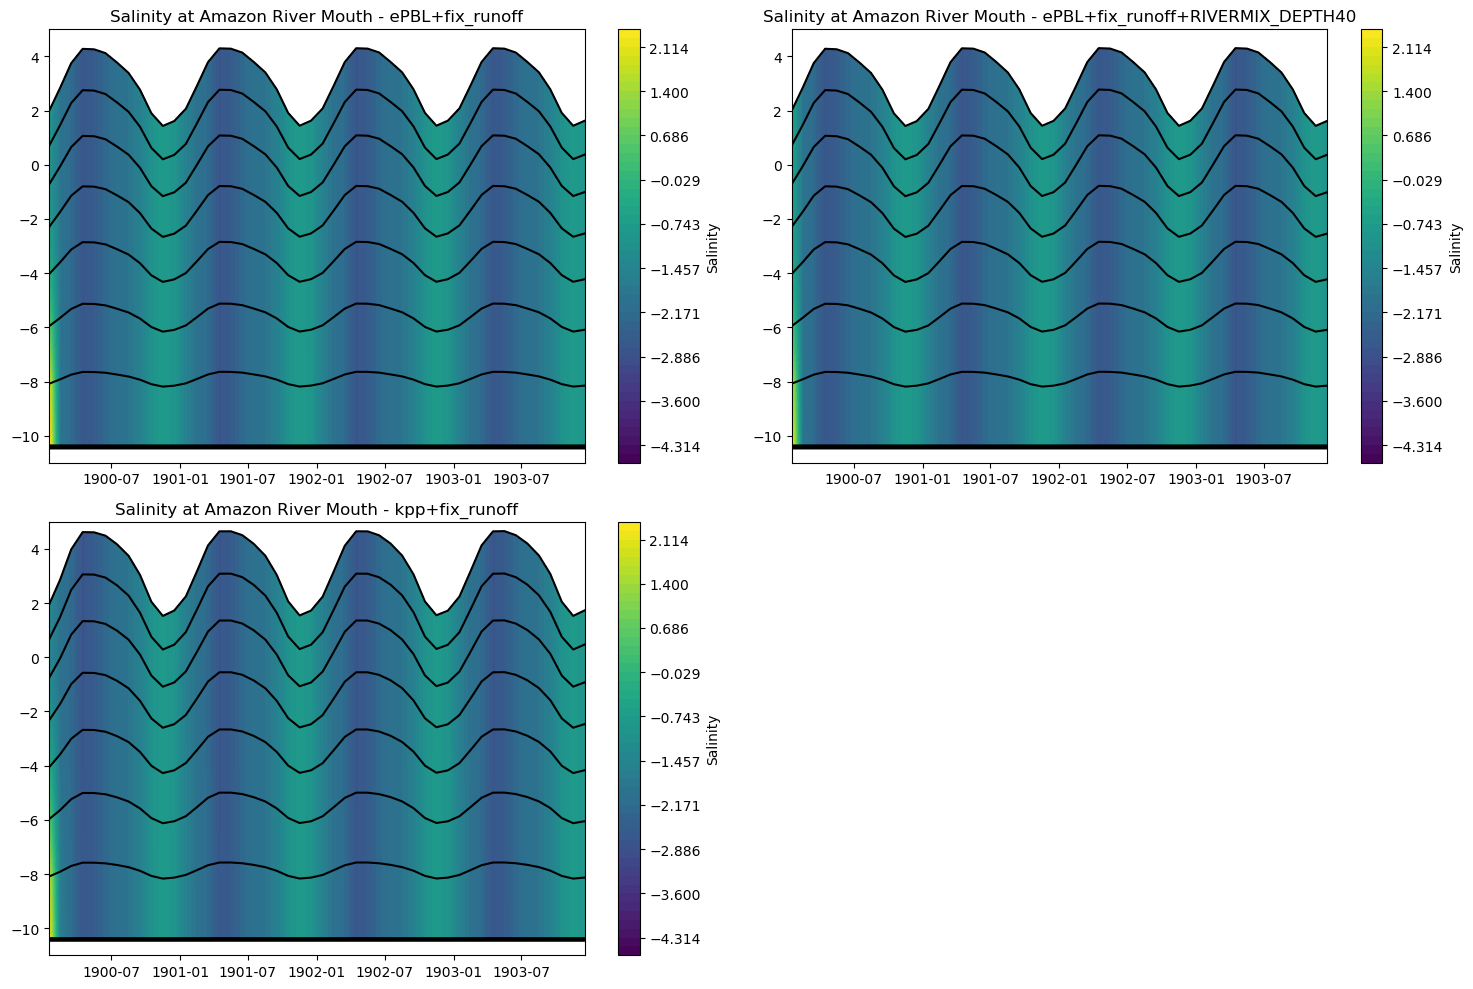

In [28]:
num_comparisons = len(e_comparisons)
ncols = 2
nrows = math.ceil(num_comparisons / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()
if num_comparisons == 1:
    axes = [axes]
for i in range(num_comparisons):
    fix_contourf(e_comparisons[i], so_comparisons[i], lat_indx[0], lon_indx[0], time_tmp, levels=50, ax=axes[i], clim=[-4.6, 2.4], np_log=True, ylim=[-11,5])
    axes[i].set_title(f'Salinity at Amazon River Mouth - {MOM_names[i]}')

for j in range(num_comparisons, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [29]:
# Runoff at (Lat: -1.375, Lon: -48.625) with 0.01720200851559639
target_lon = [-48.625]
target_lat = [-1.375]
variable_om3 = "e"
ds = e_comparisons[0]
lon_indx, lat_indx, lon, lat = construct_lon_lat(static.xh, static.yh, target_lon, target_lat, ds, variable_om3)

x.shape=(76, 48), z.shape=(76, 48), S.shape=(76, 48)
x.shape=(76, 48), z.shape=(76, 48), S.shape=(76, 48)
x.shape=(76, 48), z.shape=(76, 48), S.shape=(76, 48)


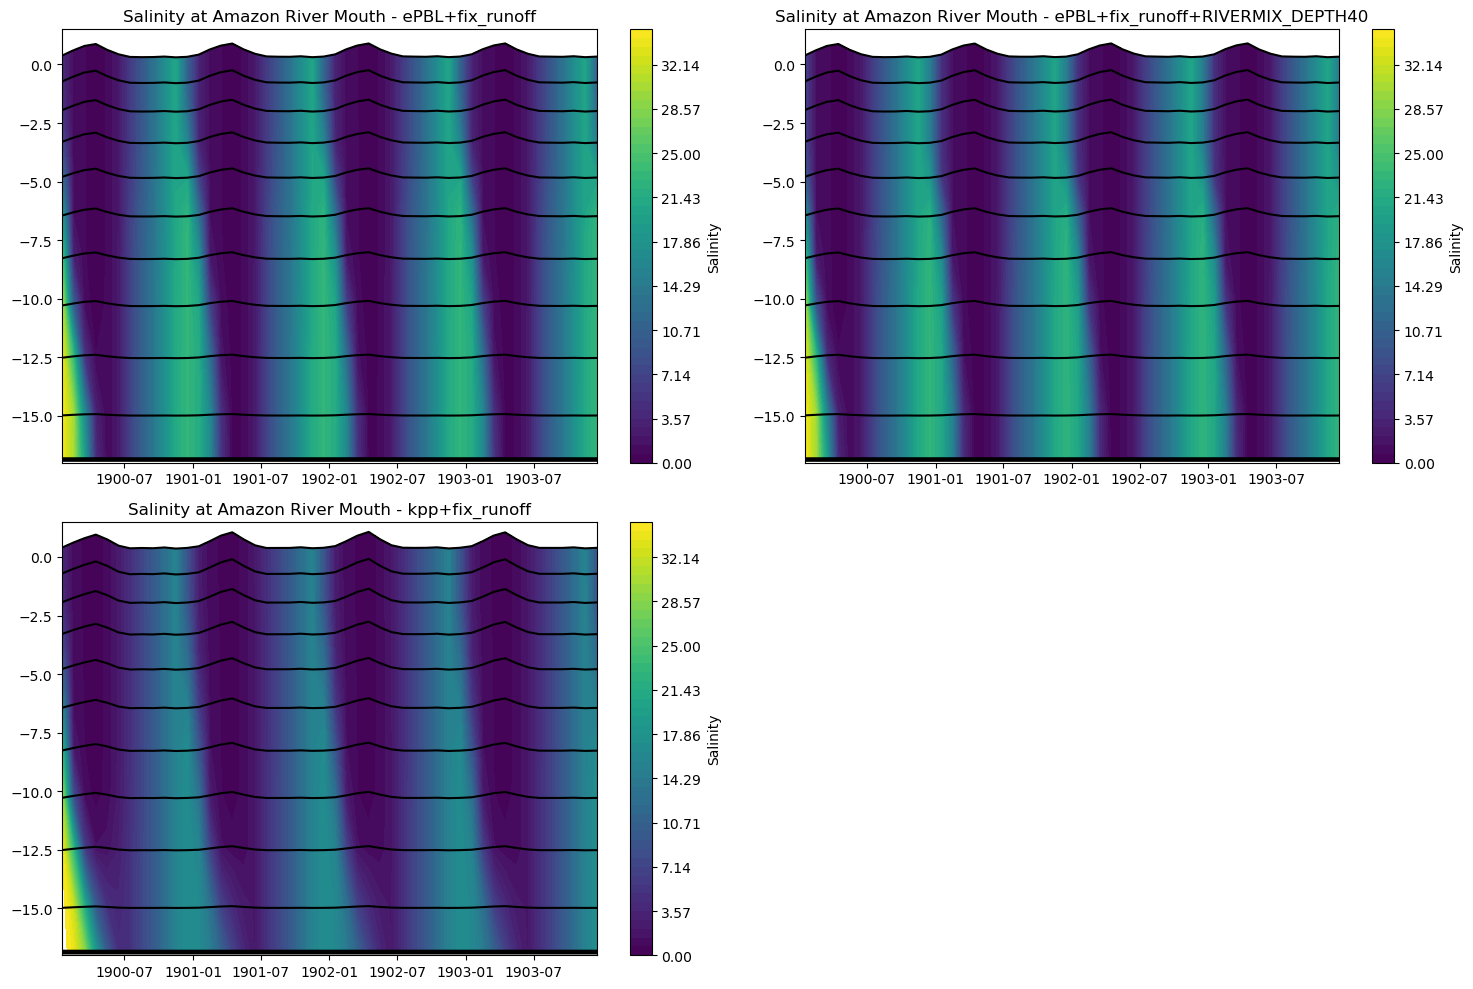

In [30]:
# Runoff at (Lat: -1.375, Lon: -48.625) with 0.01720200851559639
num_comparisons = len(e_comparisons)
ncols = 2
nrows = math.ceil(num_comparisons / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()
if num_comparisons == 1:
    axes = [axes]
for i in range(num_comparisons):
    fix_contourf(e_comparisons[i], so_comparisons[i], lat_indx[0], lon_indx[0], time_tmp, levels=50, ax=axes[i], clim=[0,35], np_log=False, ylim=[-17,1.5])
    axes[i].set_title(f'Salinity at Amazon River Mouth - {MOM_names[i]}')

for j in range(num_comparisons, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

x.shape=(76, 48), z.shape=(76, 48), S.shape=(76, 48)
x.shape=(76, 48), z.shape=(76, 48), S.shape=(76, 48)
x.shape=(76, 48), z.shape=(76, 48), S.shape=(76, 48)


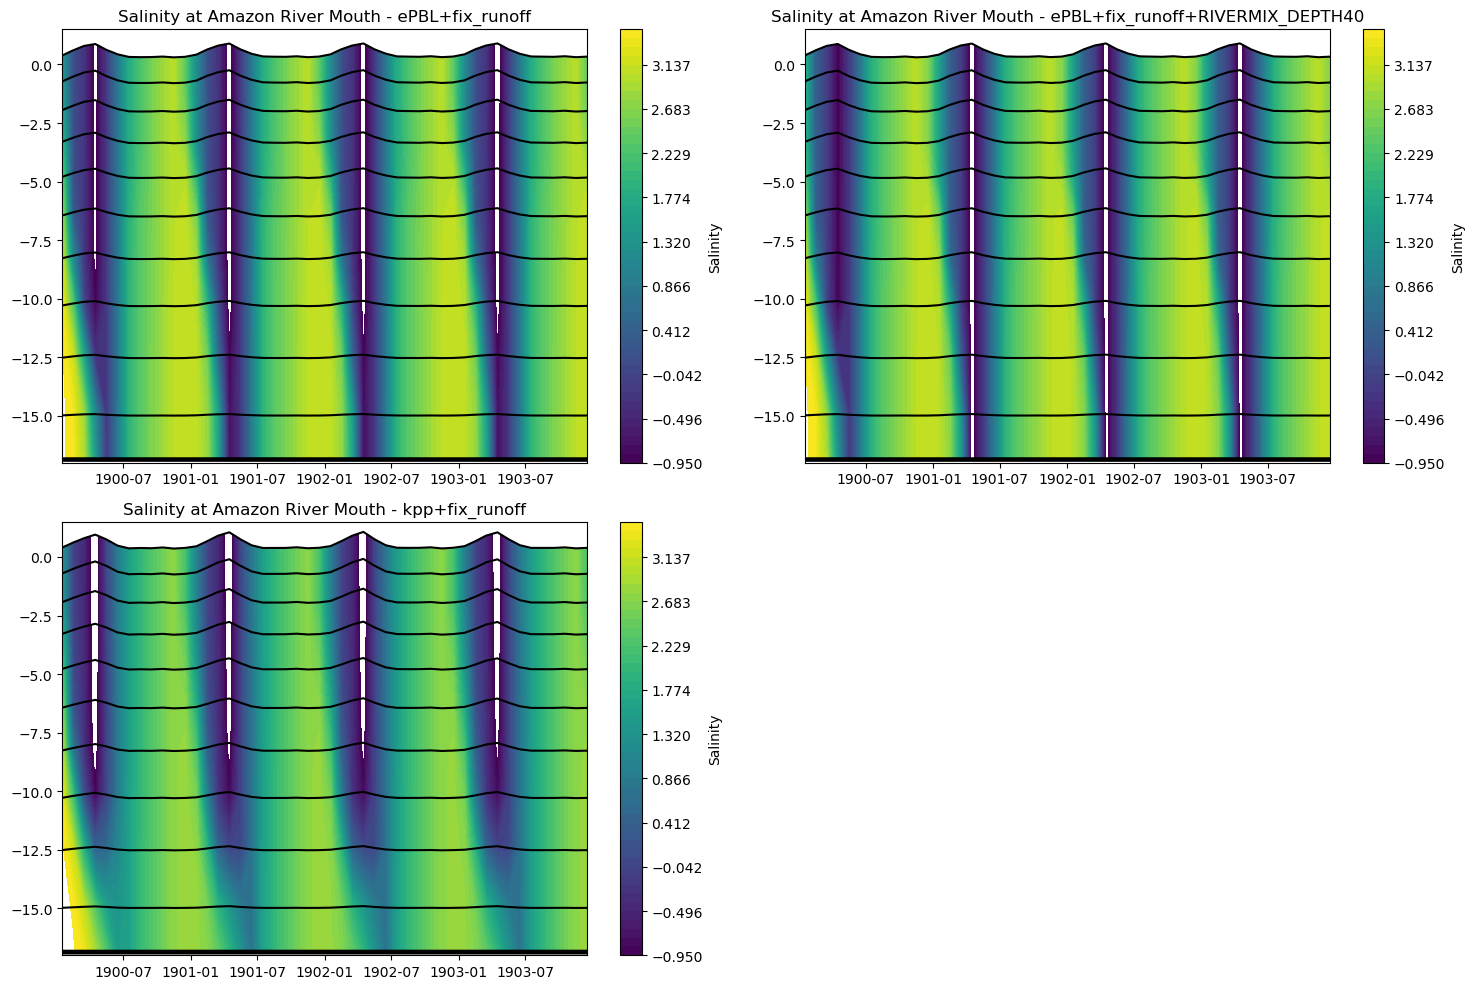

In [31]:
# Runoff at (Lat: -1.375, Lon: -48.625) with 0.01720200851559639
num_comparisons = len(e_comparisons)
ncols = 2
nrows = math.ceil(num_comparisons / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()
if num_comparisons == 1:
    axes = [axes]
for i in range(num_comparisons):
    fix_contourf(e_comparisons[i], so_comparisons[i], lat_indx[0], lon_indx[0], time_tmp, levels=50, ax=axes[i], clim=[-0.95,3.5], np_log=True, ylim=[-17,1.5])
    axes[i].set_title(f'Salinity at Amazon River Mouth - {MOM_names[i]}')

for j in range(num_comparisons, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()